#### 1

#### 2

#### 3

#### 4

https://www.quantconnect.com/docs/v2/writing-algorithms/trading-and-orders/position-sizing


The set_holdings method calculates the number of asset units to purchase based on the portfolio weight you provide and then submits market orders. This method provides a quick way to set up a portfolio with a set of weights for assets.
If the percentage you provide translates to an order quantity of 0 or to a small quantity that doesn't exceed the minimum_order_margin_portfolio_percentage algorithm setting, then the set_holdings method doesn’t place an order and doesn’t log anything. 

https://www.quantconnect.com/docs/v2/lean-engine/statistics/capacity

https://www.quantconnect.com/docs/v2/writing-algorithms/universes/key-concepts

#### Strategy1

In [ ]:
#Strategy is to buy and hold SPY until SPY drops or rises by a certain amount
#thereafter we will stay in cash for one month whereafter we will buy and hold again

# region imports
from AlgorithmImports import *
from datetime import timedelta
# endregion

class CalculatingBrownDonkey(QCAlgorithm):

    def initialize(self):
        self.set_start_date(2023, 8, 3) #start time of backtesting
        self.set_end_date(2024, 10, 31) #end time of backtesting, if not specified it is assumed today
        self.set_cash(100000) #in real life this will be taken from brokerage account balance

        spy = self.add_equity('SPY',Resolution.DAILY)        
        # self.add_forex, self.add_index_option, self.add_future  
        
        #see more normalization modes in the personal document
        #most of the time this will not be required and you can use default mode
        #spy.set_data_normalization_mode(DataNormalizationMode.RAW)

        self.spy = spy.symbol
        self.set_benchmark(self.spy)

        #Sets the brokerage to emulate in backtesting , to include fees, commissions, etc. akin to a brokerage
        #account type can be cash/ margin
        #cash account doesn't allow leverage whereas margin account does (2-4 times of balance)
        #cash accounts have T+3 settlement rules
        self.set_brokerage_model(BrokerageName.INTERACTIVE_BROKERS_BROKERAGE, AccountType.MARGIN)

        #helper variables
        self.entry_price = 0.0 # Initialize as float
        self.preriod = timedelta(31)
        self.next_entry_time = self.time        


    def on_data(self, data: Slice):
        # this is called everytime a tick event occurs or 
        # a bar reaches end time
        
        #data in such helper functions is a Slice Object
        
        #check to see if data exists

        if not data.contains_key(self.spy):
            return

        price = data.bars[self.spy].close
        # price = data[self.spy].close
        # price = self.securities[self.spy].Close

        #Strategy is to buy and hold SPY until SPY drops or rises by a certain amount
        #thereafter we will stay in cash for one month whereafter we will buy and hold again

        #if we are not invested we want to check if its time to invest


        if not self.portfolio.invested :
            if self.next_entry_time <= self.time:
                #negative quantities are interpreted as sell
                #self.market_order(self.spy,int(self.portfolio.cash/price))

                #manually calculating the order size by using set_holdings and 
                #mentioning the allocating percentage of a portfolio to given security
                #below line indicates allocating 100% of portfolio to spy

                self.set_holdings(self.spy, 1)

                self.log("Buy SPY @" + str(price))

                self.entry_price = price
                
            elif self.entry_price > 1.1*price or self.entry_price < 0.9*price:
                # we can do this using market order 
                # we can specify the symbol which we want to liquidate
                self.liquidate(self.spy)
                self.log("Sell SPY @" + str(price))

                #this ensures that for the next 31 days we stay in cash
                self.next_entry_time = self.time + self.preriod

#### Strategy 2

In [ ]:
# Strategy is buy and hold with a stop loss order

# region imports
from AlgorithmImports import *
# endregion

class WellDressedBlackCobra(QCAlgorithm):

# region imports


# endregion



    def initialize(self):
        self.set_start_date(2018, 1, 1)
        self.set_end_date(2020, 1, 1)
        self.set_cash(100000)
        
        #Invesco QQQ ETF is passively managed and tracks the Nasdaq-100 index,
        self.qqq = self.add_equity("QQQ", Resolution.HOUR).symbol
        
        #helper variables
        self.entryTicket = None #Order ticket for entering an order
        self.stopMarketTicket = None #Order ticket for order close
        self.entryTime = datetime.min
        self.stopMarkOrderFillTime = datetime.min 
        self.highestPrice = 0 #for stop loss order


    def on_data(self, data: Slice): #Event handler called at every new data point
        
        # wait for 30 days after last exit
        if (self.time - self.stopMarkOrderFillTime).days < 30:
            return
        
        #price = self.securities[self.qqq].price
        price = data.bars[self.qqq].close
        
        # send entry limit order if not invested and no open limit orders exist of qqq
        if not self.portfolio.invested and not self.transactions.GetOpenOrders(self.qqq):
            ## Calculate the fee-adjusted quantity of shares with given buying power
            #https://www.quantconnect.com/docs/v2/writing-algorithms/trading-and-orders/position-sizing
            quantity = self.calculate_order_quantity(self.qqq, 0.9)
            #placing order ticket for entering the trade- limit order
            self.entryTicket = self.limit_order(self.qqq, quantity, price, "Entry Order")
            self.entryTime = self.time


        # move limit price if not filled after 1 day
        if (self.time - self.entryTime).days > 1 and self.entryTicket.status != OrderStatus.FILLED:
            self.entryTime = self.time
            updatefields = UpdateOrderFields()
            updatefields.limit_price = price
            self.entryTicket.update(updatefields)

        # move up trailing stop price
        if self.stopMarketTicket is not None and self.portfolio.invested:
            self.highestPrice = price
            updatefields = UpdateOrderFields()
            updatefields.stop_price = price*0.95
            self.stopMarketTicket.update(updatefields)


    #This is where we define stop loss order
    def OnOrderEvent(self, orderEvent): #Event handler called at every order event
        if orderEvent.status != OrderStatus.FILLED:
            return
        
        #send stop loss order if limit order is filled and         
        # order id of current order event is same as the order id of entryticket object

        if self.entryTicket is not None and self.entryTicket.order_id == orderEvent.order_id:
            self.stopMarketTicket = self.stop_market_order(self.qqq, -self.entryTicket.quantity,
            0.95*self.entryTicket.average_fill_price)


        # save fill time of stop loss order to set pause of 30 days
        if self.stopMarketTicket is not None and self.stopMarketTicket.order_id == orderEvent.order_id:
            self.stopMarkOrderFillTime = self.time
            self.highestPrice = 0 #since we don't know what qqq price will be in a month from now




    

#### Strategy 3

In [ ]:
# Strategy is if SPY SMA indicates its in uptrend and near 52w high we go long
# is SMA indicates its in downtrend and near 52w low we go short
# https://www.youtube.com/watch?v=_BHi5Y2Aow4&list=PLtqRgJ_TIq8Y6YG8G-ETIFW_36mvxMLad&index=6


# region imports
from AlgorithmImports import *
# endregion

class AdaptableRedOrangeHippopotamus(QCAlgorithm):

    def initialize(self):
        self.set_start_date(2020, 1, 1)
        self.set_end_date(2021,1, 1)
        self.set_cash(100000)
        self.spy = self.add_equity("SPY", Resolution.DAILY).symbol

        self.sma = self.sma(self.spy, 30, Resolution.DAILY)

        #as for the first 30 days we wont have data to compute 30 SMA so we use history
        #self.history returns a pandas datatframe
        closingPrices = self.history(self.spy, 30, Resolution.DAILY)['close']
        for time, price in closingPrices.loc[self.spy].items():
            self.sma.update(time, price)
        

    def on_data(self, data: Slice):
        
        #this is like a check for warm start as for the first 30 days there 
        #would have been no sma had we not used history above
        if not self.sma.IsReady:
            return

        #more efficient way to get data here would be to use rolling window method
        # or try min and max indicators instead
        hist = self.history(self.spy, timedelta(365), Resolution.DAILY)
        # hist = self.history(self.spy, 252, Resolution.DAILY) if we fetch bars directly

        low = min(hist['low']) #historical min low
        high = max(hist['high']) #historical max high

        price  = data.bars[self.spy].close #cuurent price
        
        #if price is nearing 1 year high and is above 30 day SMA, it indicates a breakout in upward direction
        if price*1.05 >= high and self.sma.Current.value < price:
            if not self.portfolio[self.spy].IsShort:
                self.set_holdings(self.spy, 1)
        #if price is nearing 1 year low and is below 30 day SMA, it indicates a breakout in downward direction
        elif price*0.95 <= low and self.sma.Current.value > price:
            if not self.portfolio[self.spy].IsShort:
                self.set_holdings(self.spy, -1)
        else:
            self.liquidate()
        
        self.plot("Benchmark","52w-High", high)
        self.plot("Benchmark","52w-Low", low)
        self.plot("Benchmark","SMA", self.sma.Current.value)

#### Strategy 4

In [2]:
# Strategy is to compare last close and open , if its a gap up you short and if its a gap down
# you long, strategy is expecting trend reversal
# At each day end you close all open positions

In [ ]:
#Strategy is to go long in case of gap-up opening and go short in case of gap down opening
#Hypothesis is of trend reversal
#https://www.youtube.com/watch?v=rQOn9iTchIg

# region imports
from AlgorithmImports import *
# endregion

class MeasuredFluorescentPinkBuffalo(QCAlgorithm):

    def initialize(self):
        self.set_start_date(2023, 8, 5)
        self.set_start_date(2024, 12, 31)
        self.set_cash(100000)
        self.spy = self.add_equity("SPY", Resolution.MINUTE).symbol
        self.rollingWindow = RollingWindow[TradeBar](2)
        #CustomBarHandler is an event handler called every time a daily bar is consolidated from minute data
        self.consolidate(self.spy, Resolution.DAILY, self.CustomBarHandler) #consolidate minute data into daily data

        #setting a scheduler to close market position 15 days before market close
        # exit_positions is the name of the function which we want to schedule
        # This scheduler runs everytime SPY trades
        self.schedule.on(self.date_rules.every_day(self.spy), 
        self.time_rules.before_market_close(self.spy, 15), 
        self.exit_positons)        


    def CustomBarHandler(self, bar):
        self.rollingWindow.add(bar)
    
    def exit_positions(self):
        self.liquidate(self.spy)
        

    def on_data(self, data: Slice):
        if not self.rollingWindow.is_ready:
            return
        #we use 31 because US market opens at 9:30 and first minute bar is received after a minute
        if not (self.time.hour ==9 and self.time.minute==31):
            return
        #rememer in rolling window the elemnt at 0 index is most recent
        #here in rolling window the latest data is the previous day data
        #1% gap up and gap down is arbitrary, use dynamic models instead; like 30 day SPY volatility
        if data[self.spy].open >= 1.01*self.rollingWindow[0].close:
            self.set_holdings(self.spy, -1) #go short
        elif data[self.spy].open <= 0.99*self.rollingWindow[0].close:
            self.set_holdings(self.spy, 1) #go long

#### Startegy 5

In [ ]:
#Strategy is Small Size Factor Trade- get 200 most liquid stocks and then trade on 10 least market cap stocks
#rebalancing is done every month
# https://www.quantconnect.com/docs/v2/writing-algorithms/universes/key-concepts

# region imports
from AlgorithmImports import *
import datetime
# endregion

class HipsterAsparagusDinosaur(QCAlgorithm):

    def initialize(self):
        self.set_start_date(2023, 8, 5)
        self.set_end_date(2024, 8, 5)
        self.set_cash(100000)
        
        self.rebalanceTime = datetime.min #rebalnace time has been set to most recent time to start trading immediately
        self.activeStocks = set()

        self.add_universe(self.CoarseFilter, self.FineFilter)

        #default resolution is min
        self.universe_settings.resolution = Resolution.DAILY

        self.portfolioTargets = []


    def CoarseFilter(self, coarse):
        if self.time < self.rebalanceTime:
            return self.universe.unchanged
        
        self.rebalanceTime = self.time + timedelta(30) #timedelta of 30 days include weekends and hence adds 1 month to current time
        sortedByDollarVolume = sorted(coarse, key = lambda x: x.dollar_volume, reverse=True)

        #25 here is completely arbitrary choice as number of stocks from coarse filter
        return [x.symbol for x in sortedByDollarVolume if x.price > 10 and x.has_fundamental_data][:25]   
    
    
    def FineFilter(self, fine):
        sortedByPE = sorted(fine, key = lambda x: x.market_cap)
        #if market cap is missing for a security its default value is zero, we want to filter these too
        return [x.symbol for x in sortedByPE if x.market_cap > 0][:10]

    def on_securities_changed(self, changes):
        for x in changes.removed_securities:
            self.liquidate(x.symbol)
            self.activeStocks.remove(x.symbol)
        
        for x in changes.added_securities:
            self.activeStocks.add(x.symbol)

        #we create a portfolio target object--> PortfolioTarget is a class
        self.portfolioTargets = [PortfolioTarget(symbol, 1/len(self.activeStocks)) for symbol in self.activeStocks]     

    def on_data(self, data: Slice): #here we are just rebalancing
        if self.portfolioTargets == []: #portfoliotarget is unchanged and there is nothing to rebalance
            return
        
        #we check if each symbol has data
        for symbol in self.activeStocks:
            if symbol not in data:
                return
        
        self.set_holdings(self.portfolioTargets)
        self.portfolioTargets = [] #so that we don't try to rebalance before universe changes again





#### Strategy 6- Options

In [ ]:
# Strategy is Buy 1 month ATM call option if you see there is a price break out
# and close shortly before expiration


# region imports
from AlgorithmImports import *
# endregion

class HyperActiveYellowGreenLeopard(QCAlgorithm):

    def initialize(self):
        self.set_start_date(2023, 8, 6)
        self.set_end_date(2025, 1, 31)
        self.set_cash(100000)
        equity = self.add_equity("MSFT", Resolution.MINUTE)
        #equity.set_data_normalization_mode(DataNormalizationMode.RAW)
        
        self.equity = equity.symbol
        option = self.add_option("MSFT", Resolution.DAILY)

        #set filter on option data needed
        #first two arguments tell how much below and above the current asset price we want to consider
        # for strike price, as for the below we want ATM options so we keep compact strike price range
        # next we set date to expiration between 20 and 40 days
        option.set_filter(-3,3, timedelta(20), timedelta(40))

        #indicator to keep track of high price of underlying over the past month
        #inbuilt max helper indicator to be used and we specify equity as data source 
        #here we use daily resolution as smaller intra day variations are not that important
        #since we want to track high prices we mention that as the last argument
        self.high = self.max(self.equity, 21, Resolution.DAILY, Field.High)




    def on_data(self, data: Slice):
        if not self.high.is_ready:
            return
        
        #we use portfolio object to create a list of open option positions
        #we save those that are of the type option and invested

        option_invested = [x.key for x in self.portfolio if x.value.invested and x.value.type==SecurityType.OPTION ]
        
        #if option_invested is not empty it means we have an open option position
        # so we check if its about to expire since we dont want to exercise the option
        if option_invested:
            if self.time + timedelta(4) >= option_invested[0].id.date:
                self.liquidate(option_invested[0], "Too close to expiration") 
            return #return if we are already invested and there is more time left
        
        if self.securities[self.equity].price > self.high.current.value: #self.high is a max indicator
            for i in data.option_chains: #we check all available option chain and pass to method BuyCall
                chains = i.value
                self.BuyCall(chains) #BuyCall is a udf
    
    #finds the right call option and buys it
    def BuyCall(self, chains):

        #we first filter by expiration dates and take the futhest expiration date available
        expiry = sorted(chains, key = lambda x: x.Expiry, reverse = True)[0].Expiry
        #we are not taking any put option
        calls = [i for i in chains if i.Expiry == expiry and i.right== OptionRight.CALL]
        #we choose the option closest to the underlying price
        calls_contracts = sorted(calls, key = lambda x: abs(x.strike - x.underlying_last_price))

        if len(calls_contracts)==0:
            return
        self.call = calls_contracts[0]
        
        if self.call.ask_price==0:
            return
        quantity = self.portfolio.total_portfolio_value / self.call.ask_price
        quantity = int(0.05 * quantity/100)

        self.buy(self.call.symbol, quantity)

    #if you let an option to expire , quantconnect automatically exercises
    #since we dont want option to exercise because in the strategy we close them early enough
    
    #below is an example if you want to handle order exercise differently
    #you can do so in on_order_event
    # def on_order_event(self, order_event):
    #     order = self.transactions.get_order_by_id(order_event.order_id)
    #     #to check if order event is an exercise , check order type
    #     #in case you don't want any share you can liquidate
    #     if order.type == order_type.option_exercise:
    #         self.liquidate()

        









#### Strategy 7- Options

In [ ]:
# Goal is to reduce the risk associated with downward movement of held equity and 
# protection against volatility risk using put option without wasting much money in protection costs

# region imports
from AlgorithmImports import *
from datetime import timedelta

# to get pricing data for volatility or VIX
#from QuantConnect.Data.Custom.CBOE import *

# endregion

class SleepyLightBrownGaur(QCAlgorithm):

    def initialize(self):
        self.set_start_date(2023, 8, 6)
        self.set_end_date(2025, 1, 31)
        self.set_cash(100000)
        self.equity = self.add_equity("SPY", Resolution.MINUTE)
        #self.equity.set_data_normalization_mode(DataNormalizationMode.RAW)
        self.symbol = self.equity.symbol

        self.vix = self.add_data(CBOE, "VIX").symbol 
        self.rank = 0
        self.contract = str()
        self.contractsAdded = set()

        self.DaysBeforeExp = 2
        self.DTE = 25 #need options with upto these many days upto expiry
        self.OTM = 0.01
        self.lookbackIV = 150 # we compare current VIX to past 150 days of VIX data
        self.IVlvl = 0.5 #this is like a signal line , a threshold beyond which we buy put
        self.percentage = 0.9
        # how many option contracts we buy compared to the number of shares of underlying we own
        #buy 1 option for every 90 shares we own
        #standard options contract covers 100 shares of the underlying
        #so buying a put option here with options_alloc = 90 we cover more than the portfolio
        #the lower this value is the more protection we buy 
        self.options_alloc = 90 

        #scheduling of plotting function, we plot every time we trade spy
        self.schedule.On(self.date_rules.every_day(self.symbol), \
            self.time_rules.after_market_open(self.symbol, 30), \
            self.Plotting)
        
        #scheduling of VIX Rank
        self.schedule.on(self.date_rules.every_day(self.symbol), \
        self.time_rules.after_market_open(self.symbol, 30), \
        self.VIXRank)

        #we set a warm up period to ensure volatilty indicator has data
        self.set_warm_up(timedelta(self.lookbackIV))


    def VIXRank(self):
        #we access vix history using self.history method
        #resolution here is daily as we are only interested in high and low values
        #self.history returns a data frame with OHLCV columns
        history = self.history(CBOE, self.vix, self.lookbackIV, Resolution.DAILY)
        #min max scaling to get the cuurent rank
        self.rank = ((self.securities[self.vix].price - min(history[::-1]["low"]))/ (max(history[::-1]["high"]) - min(history[::-1]["low"])))
        
        

    def on_data(self, data: Slice):
        if self.is_warming_up:
            return
        
        if not self.portfolio[self.symbol].invested:
            self.set_holdings(self.symbol, self.percentage)

        if self.rank > self.IVlvl:
            self.BuyPut(data)

        if self.contract:
            if (self.contract.ID.date - self.time) <= timedelta(self.DaysBeforeExp):
                self.liquidate(self.contract)
                self.log("Closed: Too close to expiration")
                self.contract = str()



    def BuyPut(self, data):
        if self.contract == str():
            self.contract = self.OptionsFilter(data)
            return #adding new options data takes 1 iteration
        elif not self.portfolio[self.contract].invested and data.contains_key(self.contract):
            #buy 1 put option for every 90 shares of underlying security that we own
            self.buy(self.contract,round(self.portfolio[self.symbol].quantity / self.options_alloc))
    
    def OptionsFilter(self, data):
        #one way is to use set filter and to iterate over available option chain object
        #this can take a lot of time to backtest
        #instead we use option chan provider which allows you to manually
        #add only those options which you want to trade
        # at the moment option chain provider doesn't allow option greeks and option implied volatilty

        #we can filter this contracts list by strike price, expiration, option type, style
        #gets a list of option contracts for an underlying symbol at requested date
        contracts = self.option_chain_provider.get_option_contract_list(self.symbol, self.time)
        
        self.underlyingprice = self.securities[self.symbol].price #current equity price


        otm_puts = [i for i in contracts if i.id.OptionRight==OptionRight.PUT and
        self.underlyingprice - i.id.strike_price > self.OTM *self.underlyingprice and
        self.DTE - 8 < (i.id.date - data.time).days < self.DTE + 8
        ]

        if len(otm_puts)> 0:
            # get contracts closest to the days to expiry value we have set 
            # and price closest to underlying price
            # then take the first option, this is the option we want to trade 
            contract = sorted(sorted(otm_puts, key = lambda x: abs((x.ID.date - self.time).days - self.DTE)),
            key = lambda x: self.underlyingprice - x.ID.strike_price)[0] 

            if contract not in self.contractsAdded:
                self.contractsAdded.add(contract)
                self.add_option_contract(contract, Resolution.MINUTE)
            return contract
        else:
            return str()
    
    def Plotting(self):
        self.plot("Vol Chart", "Rank", self.rank)
        self.plot("Vol Chart", "lvl", self.IVlvl)
        self.plot("Data Chart", self.symbol, self.securities[self.symbol].close) 

    #     option_invested = [x.key for x in self.portfolio if x.value.invested and x.value.type == self.security_type.option]
    #     if option_invested:
    #         self.plot("Data Chart","Strike", option_invested[0].ID.strike_price)
    
    def on_order_event(self, order_event):
        self.log(str(order_event))
    












In [3]:
import pandas as pd
x = pd.DataFrame({'1':[1,0],
             '2':[2,1]
             })
x

,1,2
0,1,2
1,0,1


In [12]:
x['1'].values[0]

1

In [1]:
import os
os.getcwd()

'C:\\Users\\avi\\Possible_Project'

In [14]:
x = pd.read_csv('Custom_data1 - Sheet1.csv')
x.columns = ['date', 'value']
x.head()

,date,value
0,2025/01/02 10:00:00,0
1,2025/01/03 10:00:00,1
2,2025/01/04 10:00:00,0
3,2025/01/05 10:00:00,0
4,2025/01/06 10:00:00,0


In [12]:
x.date.iloc[0]

'2025/01/02 10:00:00'

In [5]:
from datetime import datetime
x['date'] = [datetime.strptime(i, "%Y/%m/%d %H:%M:%S") for i in x['date']]
x

,date,value
0,2025-01-02 10:00:00,0
1,2025-01-03 10:00:00,1
2,2025-01-04 10:00:00,0
3,2025-01-05 10:00:00,0
4,2025-01-06 10:00:00,0
5,2025-01-07 10:00:00,1
6,2025-01-08 10:00:00,0
7,2025-01-09 10:00:00,1
8,2025-01-10 10:00:00,0
9,2025-01-11 10:00:00,0


In [6]:
tweet = pd.read_csv('MuskTweetsPreProcessed.csv')
tweet.Time.iloc[0], tweet.Time.iloc[-1], 

('2012-11-16 17:59:47', '2017-09-29 17:39:19')

In [14]:
tweet.head(25)

,Time,Tweet
0,2012-11-16 17:59:47,RT @Jon_Favreau: My Model S just arrived and I...
1,2012-11-19 08:59:46,Just returned from a trip to London and Oxford...
2,2012-11-20 08:30:44,Was misquoted by BBC as saying Europe's rocket...
3,2012-11-20 08:38:31,These articles in Space News describe why Aria...
4,2012-11-20 08:52:03,"@YOUSRC Amos's article was fair, but his edito..."
5,2012-11-20 21:22:29,Mass. judge denies auto dealers' demand to kil...
6,2012-11-20 21:32:50,"Btw, I don't think Apple is doomed. Just won't..."
7,2012-11-21 02:37:03,RT @westcoastbill: HELLO?. ?@wired: BREAKING:...
8,2012-11-21 05:01:08,Love this picture of the Curiousity rover on M...
9,2012-11-21 07:14:07,@Thomas_Tregner Exactly!


In [7]:
for i in tweet[tweet.Time.str.contains('2012-11-20')].index:
    print(tweet.iloc[i,0], tweet.iloc[i,1])
    print('---------------')

2012-11-20 08:30:44 Was misquoted by BBC as saying Europe's rocket has no chance. Just said the [Franco-German] Ariane 5 has no chance, so go with Ariane 6.
---------------
2012-11-20 08:38:31 These articles in Space News describe why Ariane 6 vs 5: {URL} and {URL}
---------------
2012-11-20 08:52:03 @YOUSRC Amos's article was fair, but his editor chose a more sensational headline & used quotes even though I didn't actually say that.
---------------
2012-11-20 21:22:29 Mass. judge denies auto dealers' demand to kill our little Tesla store. Yay, justice prevails!  {URL}
---------------
2012-11-20 21:32:50 Btw, I don't think Apple is doomed. Just won't unseat Google from 1st place with Larry P in charge. {URL}
---------------


In [11]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
tweet_ = 'Mass. judge denies auto dealers demand to kill our little Tesla store. Yay, justice prevails! '
# sia.polarity_scores(tweet_)["compound"]
sia.polarity_scores(tweet_)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\avi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.36, 'neu': 0.387, 'pos': 0.253, 'compound': -0.4129}

In [15]:
tweet.Time.iloc[0], x.date.iloc[0]

('2012-11-16 17:59:47', '2025/01/02 10:00:00')

In [48]:
tweet.tail()

,Time,Tweet
3213,2017-09-29 09:19:21,Fly to most places on Earth in under 30 mins a...
3214,2017-09-29 09:56:12,Part 2 {URL}
3215,2017-09-29 10:39:57,@bigajm Yup :)
3216,2017-09-29 10:44:54,RT @SpaceX: BFR is capable of transporting sat...
3217,2017-09-29 17:39:19,@MeltingIce Assuming max acceleration of 2 to ...


In [27]:
import dateutil
import numpy as np

In [28]:
np.random.randint(0,1)

0

In [71]:
from dateutil import relativedelta
x = pd.date_range(pd.to_datetime('2024-1-13', format= "%Y-%m-%d"), periods=31).tolist()
x = [datetime.strftime(i + relativedelta.relativedelta(hours = 10), format ="%Y-%m-%d %H:%M:%S" ) for i in x]
x
y = [np.random.randint(0,2) for _ in range(len(x))]
custom_data = pd.DataFrame({'date':x, 'signal':y})
custom_data.iloc[0,1]=1
custom_data.to_csv('Custom_data.csv')

In [70]:
custom_data

,date,signal
0,2024-01-13 10:00:00,1
1,2024-01-14 10:00:00,1
2,2024-01-15 10:00:00,1
3,2024-01-16 10:00:00,1
4,2024-01-17 10:00:00,0
5,2024-01-18 10:00:00,0
6,2024-01-19 10:00:00,1
7,2024-01-20 10:00:00,0
8,2024-01-21 10:00:00,1
9,2024-01-22 10:00:00,0


In [65]:
# custom_data.date.iloc[1], custom_data.date.iloc[0], custom_data.date.iloc[2]

#### ML Startegy Prep

In [ ]:
# # region imports
# from AlgorithmImports import *
# from datetime import datetime 
# # endregion

# class SquareFluorescentPinkDogfish(QCAlgorithm):

#     def initialize(self):
#         self.set_start_date(2024, 1, 1)
#         self.set_end_date(2024, 2, 1)
#         self.set_cash(100000)
#         self.spy = self.add_equity("TSLA", Resolution.MINUTE).symbol
#         self.indicator = self.add_data(Signal, "CUSTOM1", Resolution.MINUTE).symbol

#         self.Schedule.On(self.DateRules.EveryDay(self.spy),
#                  self.time_rules.before_market_close(self.spy, 15),      
#                  self.ExitPositions)

#     def ExitPositions(self):
#         self.liquidate()


#     def on_data(self, data: Slice):
#         self.log("Test" + str(data.bars[self.spy].close))
#         if self.indicator not in data:
#             self.log("data is not added")
#         if self.indicator in data:
#             self.log("data is" + data[self.indicator].value)
#             received_signal = data[self.indicator].value
        
#             if received_signal == 1:
#                 self.set_holdings(self.spy, 1)
#             else:
#                 return
    

# class Signal(PythonData):    

#     def get_source(self, config, date, isLive):
#         source = "https://www.dropbox.com/scl/fi/w3gu5lmrekt1sk4jc0e9w/Custom_data.csv?dl=1"
#         return SubscriptionDataSource(source, SubscriptionTransportMedium.REMOTE_FILE)
    
#     def reader(self, config, line, date, isLive):
#         #self.log("data is not read")
        
#         if not (line.strip() and line[0].isdigit()):                
#             return None
#         #self.log("Reader Active" + str(self.time)) 
#         csv = line.split(',')
        
#         xyz = Signal()
        
        
#         xyz.symbol = config.symbol
#         xyz.time = datetime.strptime(csv[0], "%Y/%m/%d %H:%M:%S") + timedelta(minutes = 1) 
#         #xyz.end_time = signal.time +            
        
#         xyz.value = int(csv[1])
#         xyz["TopGainersRank"] = 0
#         #self.log("data is " + str(self.time))
            
            
#         # except ValueError:
#         #     #self.log("data is not read" + str(self.time))
#         #     return None
    
#         return xyz

##### Twitter Based Trade

In [ ]:
#Twitter Bot

from nltk.sentiment import SentimentIntensityAnalyzer

class MyAlgorithm(QCAlgorithm):

    def Initialize(self):
        self.SetStartDate(2012, 11, 1)
        self.SetEndDate(2017, 1, 1)
        self.SetCash(100000)
        
        self.tsla = self.AddEquity("TSLA", Resolution.Minute).Symbol
        self.musk = self.AddData(MuskTweet, "MUSKTWTS", Resolution.Minute).Symbol
        
        self.Schedule.On(self.DateRules.EveryDay(self.tsla),
                 self.TimeRules.BeforeMarketClose(self.tsla, 15),      
                 self.ExitPositions)

    def OnData(self, data):
        if self.musk in data:
            score = data[self.musk].Value
            content = data[self.musk].Tweet
            
            if score > 0.5:
                self.SetHoldings(self.tsla, 1)
            elif score < -0.5:
                self.SetHoldings(self.tsla, -1)
                
            if abs(score) > 0.5:
                self.Log("Score: " + str(score) + ", Tweet: " + content)

    def ExitPositions(self):
        self.Liquidate()


class MuskTweet(PythonData):

    sia = SentimentIntensityAnalyzer()

    def GetSource(self, config, date, isLive):
        source = "https://www.dropbox.com/s/ovnsrgg1fou1y0r/MuskTweetsPreProcessed.csv?dl=1"
        return SubscriptionDataSource(source, SubscriptionTransportMedium.RemoteFile);

    def Reader(self, config, line, date, isLive):
        if not (line.strip() and line[0].isdigit()):
            return None
        
        data = line.split(',')
        tweet = MuskTweet()
        
        try:
            tweet.Symbol = config.Symbol
            tweet.Time = datetime.strptime(data[0], '%Y-%m-%d %H:%M:%S') + timedelta(minutes=1)
            content = data[1].lower()
            
            if "tsla" in content or "tesla" in content:
                tweet.Value = self.sia.polarity_scores(content)["compound"]
            else:
                tweet.Value = 0
            
            tweet["Tweet"] = str(content)
            
        except ValueError:
            return None
        
        return tweet



In [ ]:
#Made changes
# region imports
from AlgorithmImports import *
from datetime import datetime 
# endregion

class SquareFluorescentPinkDogfish(QCAlgorithm):

    def initialize(self):
        self.set_start_date(2024, 11, 13)
        self.set_end_date(2025, 1, 31) 
        self.set_cash(100000)
        self.spy = self.add_equity("SPY", Resolution.MINUTE).symbol
        self.indicator = self.add_data(Signal, "CUSTOM1", Resolution.MINUTE).symbol

        # self.Schedule.On(self.DateRules.EveryDay(self.spy),
        #          self.time_rules.before_market_close(self.spy, 15),      
        #          self.ExitPositions)

    # def ExitPositions(self):
    #     if self.portfolio.invested:
    #         self.liquidate(self.spy)
    #     else:
    #         self.set_holdings(self.spy, 0)


    def on_data(self, data: Slice):
        # self.log("Test " + str(data.bars[self.spy].close))
        # if self.indicator not in data:
        #     self.log("data is not added")
        if self.indicator in data:
            self.log("data is " + str(data[self.indicator].value) + str(' ') + str(self.time))
            received_signal = data[self.indicator].value
        
            if received_signal == 1 and not self.portfolio.invested:
                self.set_holdings(self.spy, 1)
            elif received_signal == 0 and self.portfolio.invested: 
                self.set_holdings(self.spy, -1)
            elif received_signal == 0 and not self.portfolio.invested:
                self.set_holdings(self.spy, 0)
            else:
                return
    

class Signal(PythonData):    

    def get_source(self, config, date, isLive):
        source = "https://www.dropbox.com/scl/fi/99vp8s5rjebnz0hzdvkhg/Custom_data.csv?rlkey=5uzd6487zk8w59d85mdj22vge&st=u0nj74db&dl=1"
        return SubscriptionDataSource(source, SubscriptionTransportMedium.REMOTE_FILE)
    
    def reader(self, config, line, date, isLive):
        #self.log("data is not read")
        
        if not (line.strip() and line[0].isdigit()):                
            return None
        #self.log("Reader Active" + str(self.time)) 
        csv = line.split(',')
        
        xyz = Signal()
        
        
        xyz.symbol = config.symbol
        xyz.time = datetime.strptime(csv[1], '%Y-%m-%d %H:%M:%S') + timedelta(minutes = 1)
        #xyz.end_time = signal.time +            
        
        xyz.value = int(csv[2])
        
        
        #self.log("data is " + str(self.time))
            
            
        # except ValueError:
        #     #self.log("data is not read" + str(self.time))
        #     return None
    
        return xyz

##### External File with Signals for trading

In [ ]:
# Third attempt this worked
# region imports
from AlgorithmImports import *
from datetime import datetime 
# endregion

class SquareFluorescentPinkDogfish(QCAlgorithm):

    def initialize(self):
        self.set_start_date(2024, 1, 13)
        self.set_end_date(2024, 2, 14)
        
        self.set_cash(100000)
        self.spy = self.add_equity("MSFT", Resolution.DAILY).symbol
        self.indicator = self.add_data(Signal, "CUSTOM1", Resolution.MINUTE).symbol

        self.Schedule.On(self.DateRules.EveryDay(self.spy),
                 self.time_rules.before_market_close(self.spy, 15),      
                 self.ExitPositions)

    def ExitPositions(self):
        if self.portfolio.invested:
            self.liquidate(self.spy)
        else:
            return


    def on_data(self, data: Slice):
        #self.log("Test " + str(data.bars[self.spy].close))
        # if self.indicator not in data:
        #     self.log("data is not added")
        if self.indicator in data:
            # self.log("data is " + str(data[self.indicator].value) + str(' ') + str(self.time))
            # self.log(data.items())
            received_signal = data[self.indicator].value
        
            if received_signal == 1 :
                self.set_holdings(self.spy, 1)
                self.log("Buy Order" + str(self.time))
            else:
                self.set_holdings(self.spy, -1)
                self.log("Sell Order " + str(self.time))
    

class Signal(PythonData):    

    def get_source(self, config, date, isLive):
        source = "https://www.dropbox.com/scl/fi/bx3jv2alp72wzyrhr9hbp/Custom_data.csv?rlkey=edv0mqmew9kw0434j01zsdi0y&st=vdu12fxp&dl=1"
        return SubscriptionDataSource(source, SubscriptionTransportMedium.REMOTE_FILE)
    
    def reader(self, config, line, date, isLive):
        #self.log("data is not read")
        
        if not (line.strip() and line[0].isdigit()):                
            return None
        #self.log("Reader Active" + str(self.time)) 
        csv = line.split(',')
        
        xyz = Signal()
        
        
        xyz.symbol = config.symbol
        xyz.time = datetime.strptime(csv[1], '%Y-%m-%d %H:%M:%S') + timedelta(minutes = 1)
        #xyz.end_time = signal.time +            
        
        xyz.value = int(csv[2])
        
        
        #self.log("data is " + str(self.time))
            
            
        # except ValueError:
        #     #self.log("data is not read" + str(self.time))
        #     return None
    
        return xyz

##### First ML Based Options Trading

In [1]:
from nselib import capital_market
from nselib import derivatives
import dtale
import talib as ta

In [2]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import yfinance as yf

# spy = web.YahooOptions('SPY')
spy = yf.Ticker("SPY")

import warnings

warnings.filterwarnings('ignore')

In [3]:
df_spy = spy.history('max').loc['2019-01-01':'2024-12-31',:][['Open', 'High', 'Low', 'Close', 'Volume']]

In [12]:
# df_demo = yf.download('SPY',start = '2019-01-01', end = '2024-12-31',actions = True,multi_level_index=False )
# df_demo.head()

In [4]:
df_spy.tail()


,Open,High,Low,Close,Volume
Date,,,,,
2024-12-24 00:00:00-05:00,596.059998,601.340027,595.469971,601.299988,33160100
2024-12-26 00:00:00-05:00,599.500000,602.479980,598.080017,601.340027,41219100
2024-12-27 00:00:00-05:00,597.539978,597.780029,590.760010,595.010010,64969300
2024-12-30 00:00:00-05:00,587.890015,591.739990,584.409973,588.219971,56578800
2024-12-31 00:00:00-05:00,589.909973,590.640015,584.419983,586.080017,57052700


In [6]:
# Note: 1m data is not available , for entir history but only for last 30 days
# df_demo = yf.download('SPY',start = '2025-01-28', end = '2025-01-29',actions = True,
#                       multi_level_index=False, interval = '1m' )

####################### Comparing close price vs adjusted price ############################# 

# df_demo = yf.download('SPY',start = '2022-06-23', end = '2022-06-28',actions = True,multi_level_index=False )
# df_demo1 = yf.download('SPY',start = '2022-06-23', end = '2022-06-28',actions = True,
#                        auto_adjust=False, multi_level_index=False )
# df_demo1, df_demo


In [5]:
# define tthe periods to calculate returns
intervals = [1, 5, 10, 22, 44, 88]

#Loop to calculate returns for time in intervals

for t in intervals:
    df_spy.loc[:,'ret_{}d'.format(t)] = df_spy.Close.pct_change(t)
df_spy.tail()


,Open,High,Low,Close,Volume,ret_1d,ret_5d,ret_10d,ret_22d,ret_44d,ret_88d
Date,,,,,,,,,,,
2024-12-24 00:00:00-05:00,596.059998,601.340027,595.469971,601.299988,33160100,0.011115,-0.001599,0.000869,0.016261,0.034293,0.083183
2024-12-26 00:00:00-05:00,599.500000,602.479980,598.080017,601.340027,41219100,0.000067,0.029140,-0.006743,0.013189,0.043900,0.079545
2024-12-27 00:00:00-05:00,597.539978,597.780029,590.760010,595.010010,64969300,-0.010527,0.018619,-0.012108,-0.000866,0.030683,0.076631
2024-12-30 00:00:00-05:00,587.890015,591.739990,584.409973,588.219971,56578800,-0.011412,-0.004957,-0.023188,-0.017398,0.019273,0.053155
2024-12-31 00:00:00-05:00,589.909973,590.640015,584.419983,586.080017,57052700,-0.003638,-0.014478,-0.030880,-0.017997,0.012435,0.051831


In [6]:
#volatility indicator
df_spy.loc[:,'Norm_ATR'] = ta.NATR(df_spy.High, df_spy.Low, df_spy.Close, timeperiod =14)

macd, macdsignal, macdhist = ta.MACD(df_spy.Close, fastperiod= 12, slowperiod= 26, signalperiod= 9)

df_spy.loc[:,'macd'] = macd
df_spy.loc[:,'macdsignal'] = macdsignal

upper, middle, lower = ta.BBANDS(df_spy.Close, timeperiod = 20)
df_spy.loc[:,'Upper_BB'] = upper
df_spy.loc[:,'Middle_BB'] = middle
df_spy.loc[:,'Lower_BB'] = lower


#momentum indicator
df_spy.loc[:,'RSI'] = ta.RSI(df_spy.Close, timeperiod = 14)

#trend indicator
df_spy.loc[:,'ADX'] = ta.ADX(df_spy.High, df_spy.Low, df_spy.Close, timeperiod =14)

In [7]:
#next day return brought backwards to create target variable for next day's returns
df_spy.loc[:,'return'] = df_spy.Close.pct_change(1).shift(-1)
df_spy.loc[:,'target'] = np.where(df_spy['return'] > 0, 1, 0)

In [8]:
df_spy.loc[:,'Year_month'] = (pd.Series(df_spy.index).dt.year.astype('str') +str('_') +pd.Series(df_spy.index).dt.month.astype('str')).to_list()

<Axes: xlabel='Year_month'>

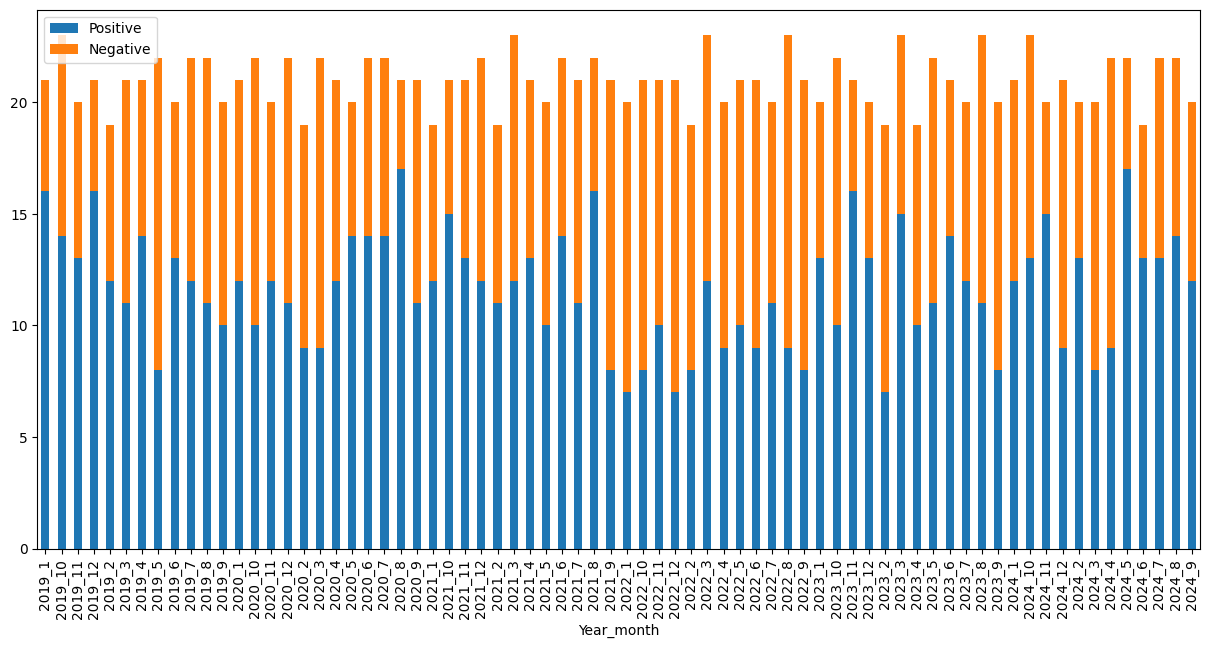

In [9]:
import matplotlib.pyplot as plt

plt_table = df_spy.groupby(['Year_month'])['target'].apply(lambda x:{
                                  'Positive':   x.value_counts()[1], 
                                  'Negative':   x.value_counts()[0]
        

}).unstack()

# plt.figure(figsize = (150, 700))
# plt.bar(plt_table, stacked=True)

plt_table.plot.bar(stacked = True,figsize = (15, 7))

In [138]:


# import seaborn as sns 
# import matplotlib.pyplot as plt 
  
# # Countplot 
# sns.catplot(x ="Year_month", hue ="target",  
# kind ="count", data = df_spy,height=10, aspect = 10,) 


In [13]:
# df_spy.isna().sum()

In [10]:
#keeping 2024 data as test , everything before as train (leaving 1st 88 data points as we use 88d returns as a predictor)

train, test = df_spy.loc['2019-05-09':'2023-12-31',: ], df_spy.loc['2024-01-02':,: ]
len(train), len(test)

(1170, 252)

In [11]:
def get_train_test_data(start_dt, end_dt, start_dt_test, end_dt_test):
    
    #train, test = df_spy.loc['2019-05-09':'2023-12-31',: ], df_spy.loc['2024-01-02':,: ]
    
    train, test = df_spy.loc[start_dt:end_dt,: ], df_spy.loc[start_dt_test:end_dt_test,: ]
    
    train_x = train.drop(columns = ['target', 'return', 'Year_month'])
    train_y = train['target']

    test_x = test.drop(columns = ['target', 'return', 'Year_month'])
    test_y = test['target']
    
    return train_x, train_y, test_x, test_y 

In [65]:
#### Random Forest Classifier

In [15]:
# Best Parameters using grid search: {'ccp_alpha': 0.0001, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 10}

In [13]:
# train_y.sum(), len(train_y), test_y.sum(), len(test_y)

In [12]:
from dateutil import relativedelta
from datetime import datetime
import calendar
dates_start, dates_end = [], ['2023-12-31']
for i in range(1, 13, 1):
    end_dt = calendar.monthrange(2024, i)[1]    
    dt_start = '2024-'+str(i).zfill(2) +str('-')+ '01'
    dt_end = '2024-'+str(i).zfill(2) +str('-')+ str(end_dt)
    dates_start.append(dt_start)
    dates_end.append(dt_end)
dates_start, dates_end


(['2024-01-01',
  '2024-02-01',
  '2024-03-01',
  '2024-04-01',
  '2024-05-01',
  '2024-06-01',
  '2024-07-01',
  '2024-08-01',
  '2024-09-01',
  '2024-10-01',
  '2024-11-01',
  '2024-12-01'],
 ['2023-12-31',
  '2024-01-31',
  '2024-02-29',
  '2024-03-31',
  '2024-04-30',
  '2024-05-31',
  '2024-06-30',
  '2024-07-31',
  '2024-08-31',
  '2024-09-30',
  '2024-10-31',
  '2024-11-30',
  '2024-12-31'])

In [72]:
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier

# tuned parameters taken from hyper parameter tuning done in the next section
params_rf =  {'ccp_alpha': 0.0001,
              'criterion': 'gini',
              'max_depth': 2,
              'min_samples_leaf': 20,
              'min_samples_split': 50,
              'n_estimators': 10}

start_dt = '2019-01-01'

def fit_rf(train_x, train_y, test_x):
    # creating a RF classifier
    # clf = RandomForestClassifier(**params_rf)  
    clf = RandomForestClassifier() 
    
    clf.fit(train_x, train_y)
    y_pred = clf.predict(test_x)
    return y_pred

In [76]:
pd.options.display.max_rows = 500

In [75]:
output = pd.DataFrame()
for i in range(12):
    train_x, train_y, test_x, test_y  = get_train_test_data(start_dt, dates_end[i], dates_start[i], dates_end[i+1])
    y_pred = fit_rf(train_x, train_y, test_x)
    final_output = pd.DataFrame({'Date':test_y.index.tolist(),
             'Signal': y_pred
             })
    final_output.Date = [ i+ relativedelta.relativedelta(hours = 15) for i in final_output.Date]
    final_output.Date = [datetime.strftime(i, format =  "%Y-%m-%d %H:%M:%S") for i in final_output.Date]
    
    output = pd.concat([output, final_output], axis = 0)
output

,Date,Signal
0,2024-01-02 15:00:00,0
1,2024-01-03 15:00:00,1
2,2024-01-04 15:00:00,0
3,2024-01-05 15:00:00,0
4,2024-01-08 15:00:00,1
...,...,...
16,2024-12-24 15:00:00,1
17,2024-12-26 15:00:00,1
18,2024-12-27 15:00:00,1
19,2024-12-30 15:00:00,1


In [81]:
test_x.tail()

,Open,High,Low,Close,Volume,ret_1d,ret_5d,ret_10d,ret_22d,ret_44d,ret_88d,Norm_ATR,macd,macdsignal,Upper_BB,Middle_BB,Lower_BB,RSI,ADX
Date,,,,,,,,,,,,,,,,,,,
2024-12-24 00:00:00-05:00,596.059998,601.340027,595.469971,601.299988,33160100,0.011115,-0.001599,0.000869,0.016261,0.034293,0.083183,1.057505,1.151352,2.618973,612.076575,599.571780,587.066986,56.013026,21.816723
2024-12-26 00:00:00-05:00,599.500000,602.479980,598.080017,601.340027,41219100,0.000067,0.029140,-0.006743,0.013189,0.043900,0.079545,1.034167,1.440339,2.383246,612.226871,599.707022,587.187173,56.048273,20.265483
2024-12-27 00:00:00-05:00,597.539978,597.780029,590.760010,595.010010,64969300,-0.010527,0.018619,-0.012108,-0.000866,0.030683,0.076631,1.097523,1.145380,2.135673,612.244233,599.616458,586.988683,49.319632,19.978006
2024-12-30 00:00:00-05:00,587.890015,591.739990,584.409973,588.219971,56578800,-0.011412,-0.004957,-0.023188,-0.017398,0.019273,0.053155,1.159611,0.359579,1.780454,612.556648,599.001016,585.445385,43.312946,20.502721
2024-12-31 00:00:00-05:00,589.909973,590.640015,584.419983,586.080017,57052700,-0.003638,-0.014478,-0.030880,-0.017997,0.012435,0.051831,1.156520,-0.430884,1.338186,612.832250,598.224756,583.617262,41.593618,20.989956


In [78]:
len(output)

252

In [82]:
output.to_csv('ml_output_update_mom.csv', index = False)

In [70]:
from sklearn import metrics
print('RF model accuracy score: {0:0.4f}'. format(metrics.accuracy_score(test_y, y_pred)))
print('--------------------------------')
# metrics.classification_report(test_y, y_pred)

RF model accuracy score: 0.4405
--------------------------------


In [71]:
y_pred.sum(), len(y_pred)

(49, 252)

In [75]:
from datetime import datetime
final_output = pd.DataFrame({'Date':test_y.index.tolist(),
             'Signal': y_pred
             })
final_output.Date = [ i+ relativedelta.relativedelta(hours = 15) for i in final_output.Date]
final_output.Date = [datetime.strftime(i, format =  "%Y-%m-%d %H:%M:%S") for i in final_output.Date]
final_output.to_csv('ml_output_update.csv', index = False)

In [75]:
# y_pred_train = clf.predict(train_x)

# print('RF model accuracy score on training data: {0:0.4f}'. format(accuracy_score(train_y, y_pred_train)))

In [74]:
pd.options.display.max_rows = 700
final_output

,Date,Signal
0,2024-01-02 15:00:00,0
1,2024-01-03 15:00:00,1
2,2024-01-04 15:00:00,1
3,2024-01-05 15:00:00,1
4,2024-01-08 15:00:00,1
5,2024-01-09 15:00:00,1
6,2024-01-10 15:00:00,1
7,2024-01-11 15:00:00,1
8,2024-01-12 15:00:00,0
9,2024-01-16 15:00:00,1


<Axes: >

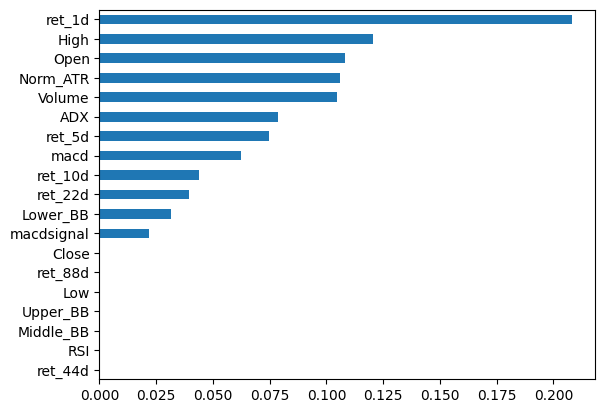

In [19]:
z = pd.Series(clf.feature_importances_, index = train_x.columns.tolist()).sort_values(ascending = False)
z[::-1].plot.barh()

In [49]:
# from datetime import datetime
# final_output = pd.DataFrame({'Date':test_y.index.tolist(),
#              'Signal': y_pred
#              })
# final_output.Date = [datetime.strftime(i, format =  "%Y-%m-%d %H:%M:%S") for i in final_output.Date]
# final_output.to_csv('ml_output.csv', index = False)

In [65]:
from dateutil import relativedelta

In [67]:
test_y.index[0] + relativedelta.relativedelta(hours = 15)

Timestamp('2024-01-02 15:00:00-0500', tz='America/New_York')

In [76]:
# final_output

In [77]:
# final_output.Signal.sum(), len(final_output)

In [64]:
#### XGBoost

In [20]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [34]:
# # define data_dmatrix
# data_dmatrix_train = xgb.DMatrix(data=train_x,label= train_y)
# data_dmatrix_test = xgb.DMatrix(data=test_x,label= test_y)

In [21]:
# parameters obtained using parameter tuning in later section
params_xgb = {
           'objective':'binary:logistic',
            #'objective':"multi:softmax",
            'max_depth': 4,
            #'alpha': 10, #L1 reguarization term on weights of learners, lambda is L2 regularization term
            'learning_rate': 0.1,
            'n_estimators':10,
            'reg_lambda':100
    
        }
            
            
            
# instantiate the classifier 
xgb_clf = XGBClassifier(**params_xgb)



# fit the classifier to the training data
xgb_clf.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
# make predictions on test data
y_pred = xgb_clf.predict(test_x)

In [23]:
# check accuracy score
from sklearn.metrics import accuracy_score

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(test_y, y_pred)))

XGBoost model accuracy score: 0.5873


In [73]:
# y_pred_train = xgb_clf.predict(train_x)

# print('XGB model accuracy score on training data: {0:0.4f}'. format(accuracy_score(train_y, y_pred_train)))

XGB model accuracy score on training data: 0.7043


<Axes: >

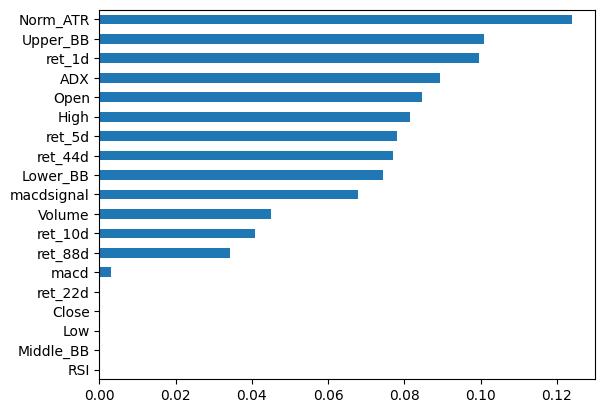

In [24]:
z = pd.Series(xgb_clf.feature_importances_, index = train_x.columns.tolist()).sort_values(ascending = False)
z[::-1].plot.barh()

In [66]:
#### LightGBM Classifier

In [25]:
import lightgbm as lgb

In [26]:
#parameters obtained using parameter tuning in later section
params_lgbm = {'learning_rate': 0.1, 'n_estimators': 10, 'reg_lambda': 100}

model = lgb.LGBMClassifier(**params_lgbm)
model.fit(train_x,train_y,eval_metric='logloss')

[LightGBM] [Info] Number of positive: 636, number of negative: 534
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 1170, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543590 -> initscore=0.174803
[LightGBM] [Info] Start training from score 0.174803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(n_estimators=10, reg_lambda=100)

In [27]:
y_pred = model.predict(test_x)

print('LightGBM model accuracy score: {0:0.4f}'. format(accuracy_score(test_y, y_pred)))

LightGBM model accuracy score: 0.5873


In [72]:
# y_pred_train = model.predict(train_x)

# print('LightGBM model accuracy score on training data: {0:0.4f}'. format(accuracy_score(train_y, y_pred_train)))

<Axes: >

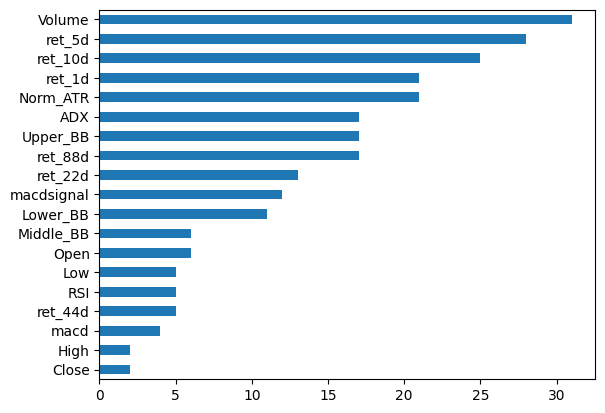

In [28]:

z = pd.Series(model.feature_importances_, index = train_x.columns.tolist()).sort_values(ascending = False)
z[::-1].plot.barh()

In [78]:
#### Neural Network Based classifier

In [29]:
import tensorflow as tf
from plot_keras_history import show_history, plot_history

from tensorflow import keras
from tensorflow.keras import layers

In [86]:

# print(keras.__version__), print(tf.__version__)

In [30]:
from tensorflow.keras.utils import to_categorical

NN_train_labels = to_categorical(train_y.values) # One-hot encoding of the label
NN_test_labels = to_categorical(test_y.values) # One-hot encoding of the label


In [31]:
from tensorflow.keras import initializers
from tensorflow.keras.constraints import non_neg

# Usage in a Keras layer:
initializer = initializers.RandomNormal()

model_NN = keras.Sequential() # This defines the structure of the network, i.e. how layers are organized
model_NN.add(layers.Dense(8, activation="tanh",           # Nb units & activation
                       input_shape=(len(train_x.columns),),    # Size of input
                       kernel_initializer=initializer,  # Initialization of weights
                       kernel_constraint = non_neg()))   # Weights should be nonneg
model_NN.add(layers.Dropout(.25))                          # Dropping out 25% units
model_NN.add(layers.Dense(4, activation="elu",             # Nb units & activation
                       bias_initializer = initializers.Constant(0.2), # Initialization of biases
                       kernel_regularizer='l2'))        # Penalization of weights 
model_NN.add(layers.Dense(2,activation='softmax'))         # Softmax for categorical output

In [32]:


model_NN.compile(   # Model specification
        optimizer=keras.optimizers.Adam(
                learning_rate=0.01,  # Optimisation method (weight updating)
                beta_1 = 0.9, # The exponential decay rate for the 1st moment estimates
                beta_2 = 0.95), # The exponential decay rate for the 2nd moment estimates
              loss=keras.losses.BinaryCrossentropy(from_logits=True),   # Loss function
              metrics=['categorical_accuracy'])  # Output metric
model_NN.summary() # Model structure



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206 (824.00 B)

 Trainable params: 206 (824.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - categorical_accuracy: 0.4932 - loss: 0.9954 - val_categorical_accuracy: 0.5873 - val_loss: 0.8019
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.5311 - loss: 0.8266 - val_categorical_accuracy: 0.5873 - val_loss: 0.7603
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - categorical_accuracy: 0.5188 - loss: 0.7979 - val_categorical_accuracy: 0.5873 - val_loss: 0.7359
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.5045 - loss: 0.7788 - val_categorical_accuracy: 0.5873 - val_loss: 0.7282
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.5138 - loss: 0.7739 - val_categorical_accuracy: 0.5873 - val_loss: 0.7282
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_accuracy: 0.5399 - loss: 0.7701 - val_categorical_accuracy: 0.5873 - val_loss: 0.7283
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - categorical_accuracy: 0.5445 - loss: 0.7632 - val_cate

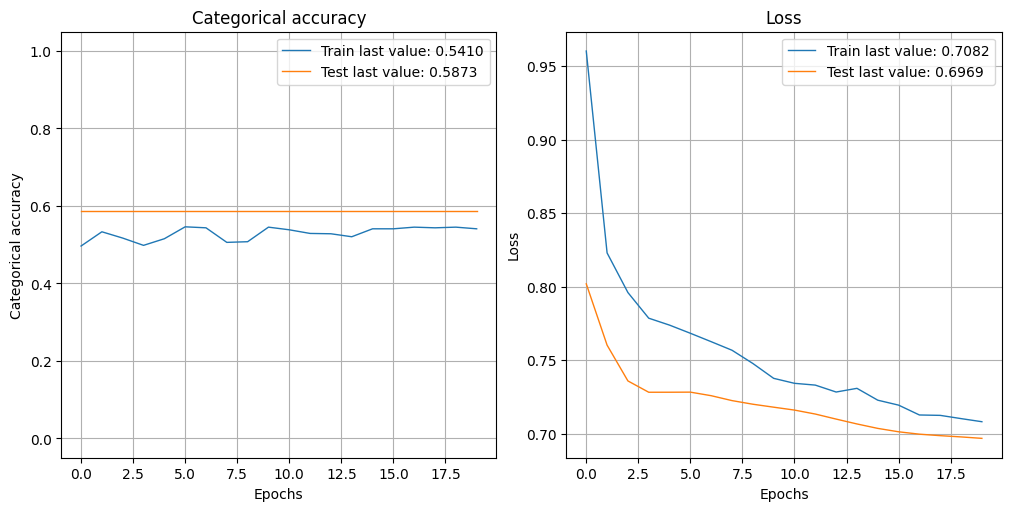

In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",    # Early stopping:
                                min_delta = 0.001,       # Improvement threshold
                                patience = 4,            # Nb epochs with no improvmt 
                                verbose = 0 )            # No warnings

fit_NN = model_NN.fit(
            train_x, # Training features
            NN_train_labels, # Training labels
            batch_size=512, # Training parameters
            epochs = 20,  # Training parameters
            validation_data=(test_x,NN_test_labels), # Test data
            verbose = True, # No comments from algo
            callbacks=[callback] # see callback above
            )
show_history(fit_NN)

In [35]:
y_pred = model_NN.predict(test_x)
# print('Neural Network Model accuracy score: {0:0.4f}'. format(accuracy_score(test_y, y_pred)))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [37]:
# y_pred

##### Ensemble Modeling

In [38]:
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(**params_rf)  
clf2 = XGBClassifier(**params_xgb)
clf3 = lgb.LGBMClassifier(**params_lgbm)

eclf1 = VotingClassifier(estimators=[
        ('rf', clf1), ('xgb', clf2), ('lgb', clf3)], voting='hard')
eclf1 = eclf1.fit(train_x, train_y)


[LightGBM] [Info] Number of positive: 636, number of negative: 534
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 1170, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543590 -> initscore=0.174803
[LightGBM] [Info] Start training from score 0.174803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [39]:
y_pred = eclf1.predict(test_x)

print('Ensemble Model with Hard Voting accuracy score: {0:0.4f}'. format(accuracy_score(test_y, y_pred)))

Ensemble Model with Hard Voting accuracy score: 0.5873


In [40]:
eclf2 = VotingClassifier(estimators=[
        ('rf', clf1), ('xgb', clf2), ('lgb', clf3)], voting='soft')
eclf2 = eclf2.fit(train_x, train_y)

[LightGBM] [Info] Number of positive: 636, number of negative: 534
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 1170, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543590 -> initscore=0.174803
[LightGBM] [Info] Start training from score 0.174803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [41]:
y_pred = eclf2.predict(test_x)

print('Ensemble Model with Soft Voting accuracy score: {0:0.4f}'. format(accuracy_score(test_y, y_pred)))

Ensemble Model with Soft Voting accuracy score: 0.5873


In [42]:
from datetime import datetime
final_output = pd.DataFrame({'Date':test_y.index.tolist(),
             'Signal': y_pred
             })
final_output.Date = [datetime.strftime(i, format =  "%Y-%m-%d %H:%M:%S") for i in final_output.Date]
final_output.to_csv('ml_output_ensemble.csv', index = False)

In [46]:
final_output.Signal.sum(), len(final_output)

(252, 252)

##### Parameter Tuning

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

###### RF

In [78]:
params_rf = {
        
        'n_estimators': [10, 50,100], # Values for nrounds
        'max_depth' : [2, 3, 4, 5],
        'min_samples_leaf' : [5, 10, 15, 20],
        'min_samples_split' : [40, 50, 60],
        'ccp_alpha' : [0.0001],
        'criterion':['gini']        
        }



In [44]:
model = RandomForestClassifier()      
model_gs = GridSearchCV(model,param_grid=params_rf,cv=2,scoring='neg_log_loss')
model_gs.fit(train_x,train_y)

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [0.0001], 'criterion': ['gini'],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'min_samples_split': [40, 50, 60],
                         'n_estimators': [10, 50, 100]},
             scoring='neg_log_loss')

In [45]:
cv_results=pd.DataFrame(model_gs.cv_results_)
print(f'Best Parameters using grid search: {model_gs.best_params_}')

Best Parameters using grid search: {'ccp_alpha': 0.0001, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 10}


In [ ]:
## BAyesian Optimisation

In [79]:
from skopt import BayesSearchCV  # module for Bayesian optimisation on the scikit learn backend
search_spaces = params_rf        # we use the param grid from previous section
model = RandomForestClassifier() 
opt = BayesSearchCV(estimator=model,          # Wrapping everything up into the Bayesian optimizer                          
                    search_spaces=search_spaces,                      
                    scoring='neg_log_loss',                                  
                    cv=2)       # cross validation with 2-fold, we keep it light for computing time sake
opt.fit(train_x,train_y)
cv_results_opt=pd.DataFrame(opt.cv_results_)

In [80]:
print(f'Best Parameters using bayes opt: {opt.best_params_}')

Best Parameters using bayes opt: OrderedDict([('ccp_alpha', 0.0001), ('criterion', 'gini'), ('max_depth', 2), ('min_samples_leaf', 20), ('min_samples_split', 60), ('n_estimators', 10)])


##### XGB

In [25]:
# scorer = make_scorer(mean_absolute_error)
# A parameter grid for RandomForest
params = {
        'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9], # Values for eta
        'n_estimators': [10, 50,100],         # Values for nrounds
        'reg_lambda': [0.01, 0.1, 1, 10, 100], # Values for lambda
        'objective': ["binary:logistic"]
    
        }

In [26]:
model = XGBClassifier()      
model_gs = GridSearchCV(model,param_grid=params,cv=2,scoring='neg_log_loss')
model_gs.fit(train_x,train_y)


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'n_estimators': [10, 50, 100],
                         'objective': ['binary:logistic'],
                         'reg_lambda': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_log_loss')

In [27]:
cv_results=pd.DataFrame(model_gs.cv_results_)
print(f'Best Parameters using grid search: {model_gs.best_params_}')

Best Parameters using grid search: {'learning_rate': 0.1, 'n_estimators': 10, 'objective': 'binary:logistic', 'reg_lambda': 100}


In [52]:
##### Bayesian Optimisation

In [28]:
from skopt import BayesSearchCV  # module for Bayesian optimisation on the scikit learn backend
search_spaces = params           # we use the param grid from previous section
opt = BayesSearchCV(estimator=model,          # Wrapping everything up into the Bayesian optimizer                          
                    search_spaces=search_spaces,                      
                    scoring='neg_log_loss',                                  
                    cv=2)                                   # cross validation with 2-fold, we keep it light for computing time sake
opt.fit(train_x,train_y)
cv_results_opt=pd.DataFrame(opt.cv_results_)

In [29]:
print(f'Best Parameters using bayes opt: {opt.best_params_}')

Best Parameters using bayes opt: OrderedDict([('learning_rate', 0.1), ('n_estimators', 10), ('objective', 'binary:logistic'), ('reg_lambda', 100)])


##### LightGBM

In [ ]:

params_lgbm = {
        'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9], # Values for eta
        'n_estimators': [10, 50,100],         # Values for nrounds
        'reg_lambda': [0.01, 0.1, 1, 10, 100], # Values for lambda L2 regularization term on weights        
        #'min_split_gain':[0.0001]
    
        }

In [58]:
model = lgb.LGBMClassifier(verbose = 0)      
model_gs = GridSearchCV(model,param_grid=params_lgbm,cv=2,scoring='neg_log_loss')
model_gs.fit(train_x,train_y)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

GridSearchCV(cv=2, estimator=LGBMClassifier(verbose=0),
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'n_estimators': [10, 50, 100],
                         'reg_lambda': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_log_loss')

In [59]:
model = lgb.LGBMClassifier(random_state=42)
model.fit(train_x,train_y,eval_metric='logloss')

LGBMClassifier(random_state=42)

In [60]:
cv_results=pd.DataFrame(model_gs.cv_results_)
print(f'Best Parameters using grid search: {model_gs.best_params_}')

Best Parameters using grid search: {'learning_rate': 0.1, 'n_estimators': 10, 'reg_lambda': 100}


In [78]:
df_demo = pd.read_csv('ml_output_old.csv')
df_demo.head(15)

,Date,Signal
0,2024-01-02 00:00:00,0
1,2024-01-03 00:00:00,1
2,2024-01-04 00:00:00,0
3,2024-01-05 00:00:00,1
4,2024-01-08 00:00:00,1
5,2024-01-09 00:00:00,1
6,2024-01-10 00:00:00,1
7,2024-01-11 00:00:00,1
8,2024-01-12 00:00:00,1
9,2024-01-16 00:00:00,1


In [85]:
df_demo.Date = [datetime.strptime(i, "%Y-%m-%d %H:%M:%S") + relativedelta.relativedelta(hours = 15) for i in df_demo.Date]

In [86]:
df_demo.Date = [datetime.strftime(i, format = "%Y-%m-%d %H:%M:%S") for i in df_demo.Date]

In [87]:
df_demo.Date.iloc[0]

'2024-01-02 15:00:00'

In [88]:
df_demo.to_csv('ml_output_old.csv', index = False)

#### Strategy Implementation on QuantConnect

In [ ]:
#Here as per signals in ml_output_old.csv we buy/sell SPY ETF


# region imports
from AlgorithmImports import *
from datetime import datetime
# endregion

class JumpingGreenChicken(QCAlgorithm):

    def initialize(self):
        self.set_start_date(2024, 1, 1)
        self.set_end_date(2024, 10, 31)
        
        self.set_cash(100000)
        self.spy = self.add_equity("SPY", Resolution.MINUTE).symbol
        self.indicator = self.add_data(Signal, "CUSTOM1", Resolution.MINUTE).symbol

        # self.set_brokerage_model(BrokerageName.INTERACTIVE_BROKERS_BROKERAGE, AccountType.MARGIN)
        self.set_brokerage_model(BrokerageName.INTERACTIVE_BROKERS_BROKERAGE, AccountType.CASH)
        self.set_benchmark(self.spy)
        

        # self.Schedule.On(self.DateRules.EveryDay(self.spy),
        #          self.time_rules.before_market_close(self.spy, 15),      
        #          self.ExitPositions)
    
    # def ExitPositions(self):
    #     if self.portfolio.invested:
    #         self.liquidate(self.spy)
    #     else:
    #         return
    def on_data(self, data: Slice):
        
        if self.indicator in data:
            
            received_signal = data[self.indicator].value
        
            if not self.portfolio.invested and received_signal == 1:
                self.set_holdings(self.spy, 1)
                self.log("Buy Order" + str(self.time) + str('  ') + str(received_signal))
            
            elif self.portfolio.invested and received_signal == 0:
                self.liquidate(self.spy)
                self.log("Sell Order" + str(self.time) + str('  ') + str(received_signal))
            else:
                # self.set_holdings(self.spy, 0)
                self.log("Do Nothing " + str(self.time) + str('  ') + str(received_signal))

class Signal(PythonData):    

    def get_source(self, config, date, isLive):
        source = "https://www.dropbox.com/scl/fi/mynxp0hpeexq2dfjeiset/ml_output_old.csv?rlkey=fd2jghurd7pgzraw8zpnw4fyf&st=yqtpi1fd&dl=1"
        return SubscriptionDataSource(source, SubscriptionTransportMedium.REMOTE_FILE)
    
    def reader(self, config, line, date, isLive):
       
        
        if not (line.strip() and line[0].isdigit()):                
            return None
         
        csv = line.split(',')
        
        xyz = Signal()
        
        
        xyz.symbol = config.symbol
        xyz.time = datetime.strptime(csv[0], '%Y-%m-%d %H:%M:%S') 
                  
        
        xyz.value = int(csv[1])      
        
    
        return xyz

In [ ]:
#Here as per signals in ml_output_old.csv we buy/sell bull call spread

In [ ]:
# region imports
from AlgorithmImports import *
# endregion

class GeekyTanDolphin(QCAlgorithm):

    def initialize(self):
        self.set_start_date(2024, 1, 1)
        self.set_end_date(2024, 10, 31)
        self.set_cash(100000)        
        
        self.universe_settings.asynchronous = True
        option = self.add_option("SPY", Resolution.MINUTE)
        self.symbol = option.symbol
        self.indicator = self.add_data(Signal, "CUSTOM1", Resolution.MINUTE).symbol

        #call_spread(min_days_till_expiry: int, higher_strike_from_atm: float, lower_strike_from_atm: float)
        #Selects two call contracts to form Bull Call Spread or Bear Call Spread Option strategies.
        
        option.set_filter(lambda universe: universe.include_weeklys().call_spread(30, 5))

        self.set_brokerage_model(BrokerageName.INTERACTIVE_BROKERS_BROKERAGE, AccountType.CASH)

    def on_data(self, data: Slice):
        # Get the OptionChain
        chain = data.option_chains.get(self.symbol, None)

        if self.indicator in data:            
            received_signal = data[self.indicator].value
            
            if (not self.portfolio.invested and received_signal == 1):    
                

                #self.log(str(self.time) + str(' ') + str(received_signal) +str(' ')+ str(len(chain)))
                
                if not chain:
                    self.log(str(self.time) + str(' ') + str('No chanin available'))
                    return
                
                # Select the call Option contracts with the furthest expiry
                expiry = max([x.expiry for x in chain])
                calls = [i for i in chain if i.expiry == expiry and i.right == OptionRight.CALL]
                if calls == 0:
                    self.log(str(self.time) + str(' ') + str('No chanin available'))
                    return
            
                # Select the ITM and OTM contract strike prices from the remaining contracts
                strikes = [x.strike for x in calls]
                otm_strike = max(strikes)
                itm_strike = min(strikes)       
                
                
                self.log("Buy Order" + str(self.time) + str('  ') + str(received_signal))

                itm_call = [x for x in calls if x.strike == itm_strike][0]
                otm_call = [x for x in calls if x.strike == otm_strike][0]

                quantity_itm = self.portfolio.total_portfolio_value*0.5 / itm_call.ask_price
                quantity_itm = int(quantity_itm/100)

                quantity_otm = self.portfolio.total_portfolio_value*0.5 / otm_call.ask_price
                quantity_otm = int(quantity_otm/100)

                quantity = min(quantity_otm, quantity_itm)

                option_strategy = OptionStrategies.bull_call_spread(self.symbol, itm_strike, otm_strike, expiry)
                
                self.buy(option_strategy, quantity)



                # legs = [
                #         Leg.create(itm_call.symbol, quantity_itm),
                #         Leg.create(otm_call.symbol, -quantity_otm)
                # ]
                # self.combo_market_order(legs, 1)

            
            elif self.portfolio.invested and received_signal == 0:
                option_invested = [x.key for x in self.portfolio if x.value.invested and x.value.type==SecurityType.OPTION ]
                
                self.liquidate()
                self.log("Sell Order" + str(self.time) + str('  ') + str(received_signal))
            
            else:
                # self.set_holdings(self.spy, 0)
                self.log("Do Nothing " + str(self.time) + str('  ') + str(received_signal))

class Signal(PythonData):   

    def get_source(self, config, date, isLive):
        source = "https://www.dropbox.com/scl/fi/mynxp0hpeexq2dfjeiset/ml_output_old.csv?rlkey=fd2jghurd7pgzraw8zpnw4fyf&st=yqtpi1fd&dl=1"
        return SubscriptionDataSource(source, SubscriptionTransportMedium.REMOTE_FILE)
    
    def reader(self, config, line, date, isLive):        
        if not (line.strip() and line[0].isdigit()):                
            return None
         
        csv = line.split(',')        
        xyz = Signal()        
        
        xyz.symbol = config.symbol
        xyz.time = datetime.strptime(csv[0], '%Y-%m-%d %H:%M:%S') 
                  
        
        xyz.value = int(csv[1])   
        return xyz

In [ ]:
#Long Strangle


In [ ]:
# region imports
from AlgorithmImports import *
# endregion

class FatRedOrangeBarracuda(QCAlgorithm):

    def initialize(self):
        self.set_start_date(2024, 1, 1)
        self.set_end_date(2024, 4, 30)
        self.set_cash(100000)        
        
        self.universe_settings.asynchronous = True
        option = self.add_option("SPY", Resolution.MINUTE)
        self.symbol = option.symbol
        self.indicator = self.add_data(Signal, "CUSTOM1", Resolution.MINUTE).symbol

        #strangle(min_days_till_expiry: int, higher_strike_from_atm: float, lower_strike_from_atm: float)
        #Selects two contracts to form Long Strangle or Short Strangle Option 
        
        option.set_filter(lambda universe: universe.include_weeklys().strangle(30, 5, -10))

        self.set_brokerage_model(BrokerageName.INTERACTIVE_BROKERS_BROKERAGE, AccountType.CASH)


    def on_data(self, data: Slice):
        # Get the OptionChain
        chain = data.option_chains.get(self.symbol, None)

        if self.indicator in data:            
            received_signal = data[self.indicator].value
            if not chain:
                self.log(str(self.time) + str(' ') + str('No chanin available'))
                return
            
            if (not self.portfolio.invested and received_signal == 1):    
                # Find options with the farthest expiry
                expiry = max([x.expiry for x in chain])
                contracts = [contract for contract in chain if contract.expiry == expiry]
                
                # Order the OTM calls by strike to find the nearest to ATM
                call_contracts = sorted([contract for contract in contracts
                    if contract.right == OptionRight.CALL and
                        contract.strike > chain.underlying.price],
                    key=lambda x: x.Strike)
                if not call_contracts:
                    return
                    
                # Order the OTM puts by strike to find the nearest to ATM
                put_contracts = sorted([contract for contract in contracts
                    if contract.right == OptionRight.PUT and
                    contract.strike < chain.underlying.price],
                    key=lambda x: x.Strike, reverse=True)
                if not put_contracts:
                    return

                call = call_contracts[0]
                put = put_contracts[0]

                quantity_call = self.portfolio.total_portfolio_value*0.5 / call.ask_price
                quantity_call = int(quantity_call/100)

                quantity_put = self.portfolio.total_portfolio_value*0.5 / put.ask_price
                quantity_put = int(quantity_put/100)

                quantity = min(quantity_call, quantity_put)

                long_strangle = OptionStrategies.strangle(self.symbol, call.strike, put.strike, expiry)
                self.buy(long_strangle, quantity)
            
            elif self.portfolio.invested and received_signal == 0:
                #option_invested = [x.key for x in self.portfolio if x.value.invested and x.value.type==SecurityType.OPTION ]
                
                self.liquidate()
                self.log("Sell Order" + str(self.time) + str('  ') + str(received_signal))
            
            else:
                # self.set_holdings(self.spy, 0)
                self.log("Do Nothing " + str(self.time) + str('  ') + str(received_signal))
            


class Signal(PythonData):   

    def get_source(self, config, date, isLive):
        source = "https://www.dropbox.com/scl/fi/mynxp0hpeexq2dfjeiset/ml_output_old.csv?rlkey=fd2jghurd7pgzraw8zpnw4fyf&st=yqtpi1fd&dl=1"
        return SubscriptionDataSource(source, SubscriptionTransportMedium.REMOTE_FILE)
    
    def reader(self, config, line, date, isLive):        
        if not (line.strip() and line[0].isdigit()):                
            return None
         
        csv = line.split(',')        
        xyz = Signal()        
        
        xyz.symbol = config.symbol
        xyz.time = datetime.strptime(csv[0], '%Y-%m-%d %H:%M:%S') 
                  
        
        xyz.value = int(csv[1])   
        return xyz

In [1]:
# Long Iron Condor

In [ ]:
# region imports
from AlgorithmImports import *
# endregion

class GeekyAsparagusBarracuda(QCAlgorithm):

    def initialize(self):
        self.set_start_date(2024, 1, 1)
        self.set_end_date(2024, 10, 31)
        self.set_cash(100000)        
        
        self.universe_settings.asynchronous = True
        option = self.add_option("SPY", Resolution.MINUTE)
        self.symbol = option.symbol
        self.indicator = self.add_data(Signal, "CUSTOM1", Resolution.MINUTE).symbol

        #iron_condor(min_days_till_expiry: int, near_strike_spread: float, far_strike_spread: float)
        #Selects four contracts to form Long Iron Condor or Short Iron Condor 
        
        option.set_filter(lambda universe: universe.include_weeklys().iron_condor(30, 5, 10))

        self.set_brokerage_model(BrokerageName.INTERACTIVE_BROKERS_BROKERAGE, AccountType.CASH)

    def on_data(self, data: Slice):
        # Get the OptionChain
        chain = data.option_chains.get(self.symbol, None)

        if self.indicator in data:            
            received_signal = data[self.indicator].value
            if not chain:
                self.log(str(self.time) + str(' ') + str('No chanin available'))
                return
            
            if (not self.portfolio.invested and received_signal == 1):
                expiry = max([x.expiry for x in chain])
                chain = sorted([x for x in chain if x.expiry == expiry], key = lambda x: x.strike)

                put_contracts = [x for x in chain if x.right == OptionRight.PUT]
                call_contracts = [x for x in chain if x.right == OptionRight.CALL]

                if len(call_contracts) < 2 or len(put_contracts) < 2:
                    return
                
                # Select the strategy legs
                near_call = call_contracts[0]
                far_call = call_contracts[1]
                near_put = put_contracts[1]
                try:
                    far_put = [x for x in put_contracts if x.Strike == (near_put.strike - far_call.strike + near_call.strike)][0]
                except:
                    return
                iron_condor = OptionStrategies.iron_condor(
                                self.symbol, 
                                far_put.strike,
                                near_put.strike,
                                near_call.strike,
                                far_call.strike,
                                expiry)

                self.buy(iron_condor, 2)
            
            elif self.portfolio.invested and received_signal == 0:
                #option_invested = [x.key for x in self.portfolio if x.value.invested and x.value.type==SecurityType.OPTION ]
                
                self.liquidate()
                self.log("Sell Order" + str(self.time) + str('  ') + str(received_signal))
            
            else:
                # self.set_holdings(self.spy, 0)
                self.log("Do Nothing " + str(self.time) + str('  ') + str(received_signal))

class Signal(PythonData):   

    def get_source(self, config, date, isLive):
        source = "https://www.dropbox.com/scl/fi/mynxp0hpeexq2dfjeiset/ml_output_old.csv?rlkey=fd2jghurd7pgzraw8zpnw4fyf&st=yqtpi1fd&dl=1"
        return SubscriptionDataSource(source, SubscriptionTransportMedium.REMOTE_FILE)
    
    def reader(self, config, line, date, isLive):        
        if not (line.strip() and line[0].isdigit()):                
            return None
         
        csv = line.split(',')        
        xyz = Signal()        
        
        xyz.symbol = config.symbol
        xyz.time = datetime.strptime(csv[0], '%Y-%m-%d %H:%M:%S') 
                  
        
        xyz.value = int(csv[1])   
        return xyz


In [2]:
#Short Iron Condor

In [ ]:
# region imports
from AlgorithmImports import *
# endregion

class JumpingYellowGreenGaur(QCAlgorithm):

    def initialize(self):
        self.set_start_date(2024, 1, 1)
        self.set_end_date(2024, 4, 30)
        self.set_cash(100000)        
        
        self.universe_settings.asynchronous = True
        option = self.add_option("SPY", Resolution.MINUTE)
        self.symbol = option.symbol
        self.indicator = self.add_data(Signal, "CUSTOM1", Resolution.MINUTE).symbol

        #iron_condor(min_days_till_expiry: int, near_strike_spread: float, far_strike_spread: float)
        #Selects four contracts to form Long Iron Condor or Short Iron Condor 
        
        option.set_filter(lambda universe: universe.include_weeklys().iron_condor(30, 5, 10))

        self.set_brokerage_model(BrokerageName.INTERACTIVE_BROKERS_BROKERAGE, AccountType.CASH)


    def on_data(self, data: Slice):
        # Get the OptionChain
        chain = data.option_chains.get(self.symbol, None)

        if self.indicator in data:            
            received_signal = data[self.indicator].value
            if not chain:
                self.log(str(self.time) + str(' ') + str('No chanin available'))
                return
            
            if (not self.portfolio.invested and received_signal == 1):
                # Find put and call contracts with the farthest expiry       
                expiry = max([x.expiry for x in chain])
                chain = sorted([x for x in chain if x.expiry == expiry], key = lambda x: x.strike)

                put_contracts = [x for x in chain if x.right == OptionRight.PUT]
                call_contracts = [x for x in chain if x.right == OptionRight.CALL]

                if len(call_contracts) < 2 or len(put_contracts) < 2:
                    return
                
                # Select the strategy legs
                far_put = put_contracts[0]
                near_put = put_contracts[1]
                near_call = call_contracts[0]
                far_call = call_contracts[1]

                quantity_far_put = self.portfolio.total_portfolio_value*0.25 / far_put.ask_price
                quantity_near_put = self.portfolio.total_portfolio_value*0.25 / near_put.ask_price
                quantity_near_call = self.portfolio.total_portfolio_value*0.25 / near_call.ask_price
                quantity_far_call = self.portfolio.total_portfolio_value*0.25 / far_call.ask_price

                quantity = min(quantity_far_put, quantity_near_put,quantity_near_call,quantity_far_call)
                quantity = int(quantity/ 100)
                short_iron_condor = OptionStrategies.short_iron_condor(
                                    self.symbol, 
                                    far_put.strike,
                                    near_put.strike,
                                    near_call.strike,
                                    far_call.strike,
                                    expiry)

                self.buy(short_iron_condor, quantity)
            
            elif self.portfolio.invested and received_signal == 0:
                #option_invested = [x.key for x in self.portfolio if x.value.invested and x.value.type==SecurityType.OPTION ]
                
                self.liquidate()
                self.log("Sell Order" + str(self.time) + str('  ') + str(received_signal))
            
            else:
                # self.set_holdings(self.spy, 0)
                self.log("Do Nothing " + str(self.time) + str('  ') + str(received_signal))

class Signal(PythonData):   

    def get_source(self, config, date, isLive):
        source = "https://www.dropbox.com/scl/fi/mynxp0hpeexq2dfjeiset/ml_output_old.csv?rlkey=fd2jghurd7pgzraw8zpnw4fyf&st=yqtpi1fd&dl=1"
        return SubscriptionDataSource(source, SubscriptionTransportMedium.REMOTE_FILE)
    
    def reader(self, config, line, date, isLive):        
        if not (line.strip() and line[0].isdigit()):                
            return None
         
        csv = line.split(',')        
        xyz = Signal()        
        
        xyz.symbol = config.symbol
        xyz.time = datetime.strptime(csv[0], '%Y-%m-%d %H:%M:%S') 
                  
        
        xyz.value = int(csv[1])   
        return xyz


Designed a machine learning-driven intraday trading model utilizing a Majority Voting classifier (RF/XGBoost/LGBM) on historical data to generate trade signals, optimizing Long Iron Condor positions on SPY ETF for improved risk-adjusted returns.